# TP2 Mean Shift

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

Return your work by e-mail using a single file (ipynb or zip) with the format 'introvis18_tp2_yourname.ipynb'


## 0. Imports

In [1]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

#%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

from skimage.color import rgb2luv,luv2rgb
# for colorspace conversions

import random as rd

from drawnow import drawnow



## 1. Mean shift

In this section, we will implement Mean Shift and test is on simple synthetic data (i.e. points you will sample from a probability distribution with known density - see below).

1: Generate a random vector of 100 2D points 'data1' with 50 points sampled from a Gaussian distribution of variance 1 centered in (0,0) and 50 points sampled from a Gaussian distribution of variance 1 centered in (2,1). Plot your points using the 'plt.scatter' function. This 'data' vector will be the synthetic data you will try to cluster, and for which the algorithm should manage to separate the point coming from each of the two Gaussians. Repeat to create a vector 'data2' with the center of the second Gaussian in (3,3). Which will be the easiest data vector to cluster? Test both in the following experiments.

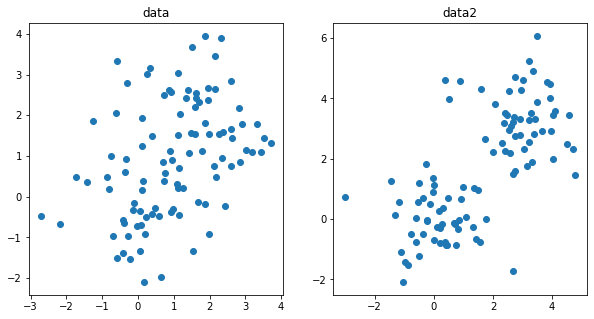

In [2]:
def compute_vector(mean1, var1, mean2, var2, nb_points):
    
    N = nb_points//2
    
    data1 = np.random.multivariate_normal(2*[mean1], np.diag(2*[var1]), N)
    data2 = np.random.multivariate_normal(2*[mean2], np.diag(2*[var2]), N)
    
    return np.concatenate((data1, data2))


data = compute_vector(0, 1, 2, 1, 100)
data2 = compute_vector(0, 1, 3, 1, 100) # plus facile à clusteriser car les 2 nuages de points sont plus espacés

fig = plt.figure(figsize = (10,5))
    
ax = fig.add_subplot(1, 2, 1)
ax.set_title("data")
ax.scatter(*data.T)
    
ax = fig.add_subplot(1, 2, 2)
ax.set_title("data2")
ax.scatter(*data2.T)

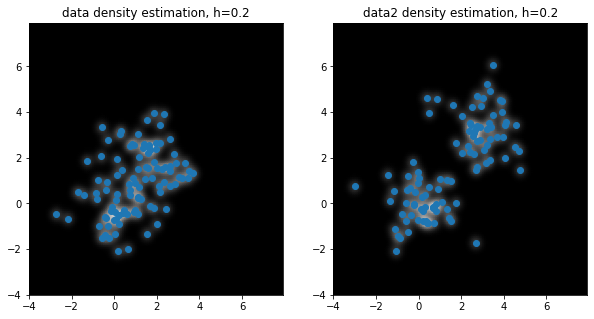

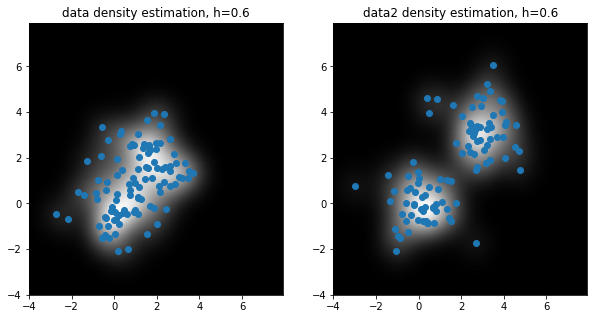

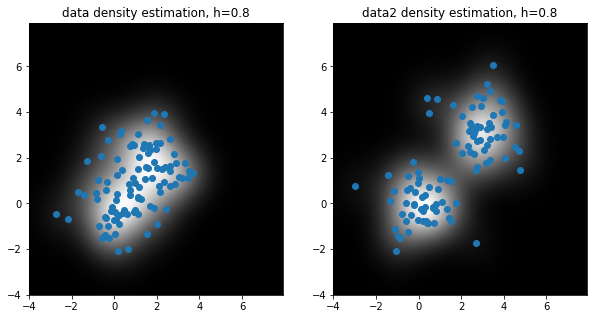

In [3]:
def norm2(x):
    return np.sum(x**2)

def k_n(r):
    return np.exp(-0.5*r)

def k_e(r):
    return 1-r if 0<=r<=1 else 0


def kernel_density_estimator(x, y, data, h, k=k_n):
    n = len(data)
    sum = 0
    for i in range(n):
        sum += k( ((x-data[i][0])**2 + (y-data[i][1])**2)/(h**2) )
    return sum/(len(data) * h)

x = np.arange(-4,8,0.1)    
X,Y = np.meshgrid(x,x)

Test = [0.2, 0.6, 0.8]
for t in Test:
    
    fig = plt.figure(figsize = (10,5))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title("data density estimation, h="+str(t))
    ax.pcolormesh(X, Y, kernel_density_estimator(X,Y, data, t, k_n), shading="gouraud")
    ax.scatter(*data.T)

    
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title("data2 density estimation, h="+str(t))
    ax.pcolormesh(X, Y, kernel_density_estimator(X,Y, data2, t), shading="gouraud")
    ax.scatter(*data2.T)

plt.show()

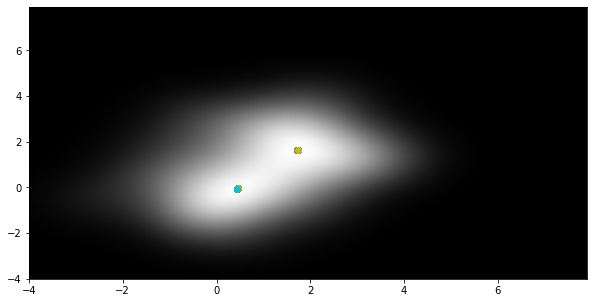

In [4]:
def m(elem, data, h, dist=norm2, kernel=k_n):
    n = len(data)
    sum1 = 0
    sum2 = 0
    for i in range(n):
        ker = -kernel( dist((elem-data[i])/h) )
        sum1 += data[i]* ker
        sum2 += ker
        
    return sum1/(sum2 + 1e-16)


def mean_shift_algo(elem, data, h, eps = 0.00001, kernel=k_n, dist=norm2 ):
    
    elem2 = m(elem, data, h, dist, kernel)
    while(dist(elem2-elem)>eps):
        elem = elem2
        elem2 = m(elem, data, h, dist, kernel)
        
    return elem2



H = 0.8

x = np.arange(-4,8,0.1)    
X,Y = np.meshgrid(x,x)
plt.figure(figsize=(10,5))
plt.pcolormesh(X, Y, kernel_density_estimator(X, Y, data, H, k_n ), shading="gouraud")

for i in range(99):
    converge = mean_shift_algo(data2[i], data, H, kernel=k_n)
    plt.scatter(*converge)

plt.show()

# 2. Segmentation

In [5]:
def Ksr(x, hs, hr, k=k_n, dist=norm2):
    xs = x[0:2]
    xr = x[2:]
    return k(dist(xs/hs))*k(dist(xr/hr))
    

def Img_to_data(Img):
    Out = []
    for i in range(Img.shape[0]):
        for j in range(Img.shape[1]):
            Out.append([i,j,*Img[i][j]])
    return np.array(Out)


def msr(elem, data, hs, hr, dist=norm2, kernel=k_n):
    n = len(data)
    sum1 = 0
    sum2 = 0
    for i in range(n):
        ker = -Ksr(elem,hs,hr,kernel,dist)
        sum1 += data[i]* ker
        sum2 += ker
        
    return sum1/(sum2 + 1e-16)

def ms_filtering(Img, hs, hr, dist=norm2, k=k_n, eps_s=2, eps_r=0.00001):
    data = Img_to_data(Img)
    z = np.zeros(data.shape)
    
    for i in range(len(data)):
        print('step: '+str(i+1)+'/'+str(len(data))+'\r', sep=' ', end='', flush=True)
        elem = data[i]
        elem2 = msr(elem, data, hs, hr, dist, k)
        
        while(dist(elem[0:2]-elem2[0:2])>eps_s or dist(elem[2:]-elem2[2:])>eps_r):
            elem = elem2
            elem2 = msr(elem, data, hs, hr, dist, k)
            print(elem2)
                        
        z[i] = np.concatenate((data[i][0:2], elem2[2:]))
        print(z[i])
        
    return z

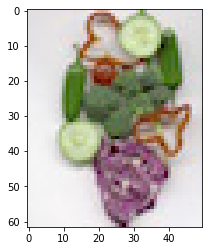

In [6]:
name='legumes_small.jpg'

I = plt.imread(name)
plt.imshow(I)

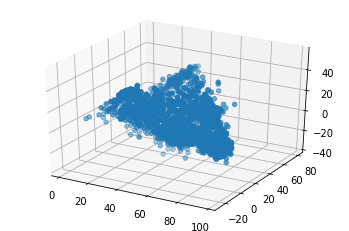

In [7]:
I_luv = rgb2luv(I)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*I_luv.T)

In [10]:
z = ms_filtering(I_luv, 5, 20)

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.          0.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.          1.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.          2.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.          3.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.          4.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.         41.         71.46588784  4.70186926  8.30517077]
[-5.65274810e-36 -4.54073208e-36 -1.32394794e-35 -8.71049155e-37
 -1.53858212e-36]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.         42.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.         43.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 0.         44.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378  

[30.51277948 24.51026548 71.46494205  4.70180703  8.30506086]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 1.         33.         71.46588784  4.70186926  8.30517077]
[30.51278037 24.5102662  71.46494414  4.70180717  8.3050611 ]
[30.51318332 24.51058988 71.46588791  4.70186926  8.30517078]
[ 1.         34.         71.46588791  4.70186926  8.30517078]
[30.51281028 24.51029023 71.46501419  4.70181178  8.30506924]
[30.51318428 24.51059065 71.46589016  4.70186941  8.30517104]
[ 1.         35.         71.46589016  4.70186941  8.30517104]
[30.51296479 24.51041434 71.46537607  4.70183559  8.30511129]
[30.51318924 24.51059464 71.46590178  4.70187017  8.30517239]
[ 1.         36.         71.46590178  4.70187017  8.30517239]
[30.51315325 24.51056572 71.46581747  4.70186463  8.30516259]
[ 1.         37.         71.46581747  4.70186463  8.30516259]
[30.51652734 24.51327606 71.47372003  4.70238455  8.30608096]
[30.51330416 24.51068695 71.46617094  4.70188788  8.30520367]
[30.5132

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 2.         22.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 2.         23.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 2.         24.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 2.         25.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 2.         26.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 3.         11.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 3.         12.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 3.         13.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 3.         14.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 3.         15.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 4.          0.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 4.          1.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 4.          2.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 4.          3.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 4.          4.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 4.         41.         71.46588784  4.70186926  8.30517077]
[31.25564755 25.10699558 73.20483677  4.81627783  8.50725694]
[30.58238    24.5661741  71.62795562  4.71253199  8.32400494]
[30.5156212  24.51254818 71.47159774  4.70224492  8.30583432]
[30.51327484 24.5106634  71.46610225  4.70188336  8.30519569]
[30.51319921 24.51060264 71.46592511  4.70187171  8.3051751 ]
[ 4.         42.         71.46592511  4.70187171  8.3051751 ]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 4.         43.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 4.         44.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 6.         22.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 6.         23.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 6.         24.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 6.         25.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 6.         26.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.46494201  4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 7.         13.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 7.         14.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 7.         15.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 7.         16.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 7.         17.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 8.          4.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 8.          5.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 8.          6.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 8.          7.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[ 8.          8.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.512792   24.51027554 71.46497138  4.70180896  8.30506427]
[30.5131837  24.51059018 71.46588878  4.70186932  8.30517088]
[ 9.         39.         71.46588878  4.70186932  8.30517088]
[30.51333999 24.51071573 71.46625485  4.7018934   8.30521342]
[30.5132013  24.51060432 71.46593001  4.70187203  8.30517567]
[ 9.         40.         71.46593001  4.70187203  8.30517567]
[30.52255726 24.51811976 71.48784289  4.70331372  8.3077222 ]
[30.513501   24.51084506 71.46663194  4.70191821  8.30525724]
[30.51320648 24.51060848 71.46594214  4.70187283  8.30517708]
[ 9.         41.         71.46594214  4.70187283  8.30517708]
[32.00108422 25.70578896 74.95074747  4.93114444  8.71015215]
[31.04849219 24.94059209 72.71965167  4.78435663  8.45087277]
[30.54917981 24.53950509 71.5501964   4.70741607  8.31496841]
[30.51440594 24.51157198 71.46875144  4.70205766  8.30550355]
[30.51323561 24.51063188 71.46601037  4.70187732  8.30518501]
[ 9.         42.         71.46601037  4.70187732  8.30518501]
[30.5   

[30.51278063 24.51026641 71.46494476  4.70180721  8.30506117]
[30.51318333 24.51058989 71.46588793  4.70186926  8.30517078]
[10.         30.         71.46588793  4.70186926  8.30517078]
[30.51278244 24.51026786 71.46494899  4.70180749  8.30506166]
[30.51318339 24.51058994 71.46588806  4.70186927  8.30517079]
[10.         31.         71.46588806  4.70186927  8.30517079]
[30.51278854 24.51027276 71.46496328  4.70180843  8.30506332]
[30.51318359 24.51059009 71.46588852  4.7018693   8.30517085]
[10.         32.         71.46588852  4.7018693   8.30517085]
[30.51279262 24.51027604 71.46497282  4.70180906  8.30506443]
[30.51318372 24.5105902  71.46588883  4.70186932  8.30517088]
[10.         33.         71.46588883  4.70186932  8.30517088]
[30.5128932  24.51035683 71.46520841  4.70182456  8.30509181]
[30.51318695 24.51059279 71.46589639  4.70186982  8.30517176]
[10.         34.         71.46589639  4.70186982  8.30517176]
[30.51320296 24.51060566 71.4659339   4.70187229  8.30517612]
[10.    

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[11.         21.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[11.         22.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[11.         23.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[11.         24.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[11.         25.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[12.         12.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[12.         13.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[12.         14.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[12.         15.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[12.         16.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.          2.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.          3.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.          4.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.          5.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.          6.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.         43.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.         44.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.         45.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[13.         46.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51278232 24.51026776 71.4649487   4.70180747  8.30506163]
[30.51318339 24.51058993 71.46588805  4.70186927  8.30517079]
[14.         36.         71.46588805  4.70186927  8.30517079]
[30.51278801 24.51027233 71.46496202  4.70180834  8.30506318]
[30.51318357 24.51059008 71.46588848  4.7018693   8.30517084]
[14.         37.         71.46588848  4.7018693   8.30517084]
[30.51310376 24.51052597 71.46570156  4.701857    8.30514912]
[30.51319371 24.51059822 71.46591223  4.70187086  8.3051736 ]
[14.         38.         71.46591223  4.70187086  8.3051736 ]
[30.52111741 24.51696316 71.48447058  4.70309185  8.3073303 ]
[30.51345373 24.51080709 71.46652124  4.70191093  8.30524438]
[30.51320496 24.51060726 71.46593858  4.70187259  8.30517666]
[14.         39.         71.46593858  4.70187259  8.30517666]
[30.53035131 24.52438056 71.50609758  4.70451473  8.30984361]
[30.51375979 24.51105295 71.46723808  4.70195809  8.30532768]
[30.5132148  24.51061517 71.46596164  4.70187411  8.30517934]
[14.    

[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[15.         25.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[15.         26.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[15.         27.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[15.         28.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.46494201  4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[15.         29.         71.46588784  4.70186926  8.30517077]
[30.51277947 24.51026547 71.46494202  4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[16.         14.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[16.         15.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[16.         16.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[16.         17.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[16.         18.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.          4.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.          5.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.          6.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.          7.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.          8.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.         44.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.         45.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.         46.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[17.         47.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51830287 24.51470231 71.47787856  4.70265815  8.30656423]
[30.51336182 24.51073326 71.46630597  4.70189677  8.30521936]
[30.513202   24.51060489 71.46593166  4.70187214  8.30517586]
[18.         37.         71.46593166  4.70187214  8.30517586]
[30.57474794 24.56004343 71.61008034  4.71135594  8.32192762]
[30.51533294 24.51231662 71.47092259  4.7022005   8.30575586]
[30.51326552 24.51065591 71.46608043  4.70188193  8.30519315]
[30.51319891 24.5106024  71.46592441  4.70187166  8.30517502]
[18.         38.         71.46592441  4.70187166  8.30517502]
[38.54185411 30.95985002 90.27009067  5.93903157 10.49043874]
[-1.75755149e-05 -1.41180366e-05 -4.11641672e-05 -2.70826457e-06
 -4.78375696e-06]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[18.         39.         71.46588784  4.70186926  8.30517077]
[-7.70420995e-13 -6.18862767e-13 -1.80442728e-12 

[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[19.         25.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[19.         26.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.46494201  4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[19.         27.         71.46588784  4.70186926  8.30517077]
[30.51277948 24.51026549 71.46494206  4.70180703  8.30506086]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[19.         28.         71.46588784  4.70186926  8.30517077]
[30.51277961 24.51026559 71.46494237  4.70180705  8.30506089]
[30.5131833  24.51058986 71.46588785  4.70186926  8.30517077]
[19.         29.         71.46588785  4.70186926  8.30517077]
[30.51277955 24.51026554 71.46494221  4.70180704  8.30506087]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[20.         14.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[20.         15.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[20.         16.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[20.         17.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[20.         18.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.          2.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.          3.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.          4.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.          5.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.          6.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.         44.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.         45.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.         46.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[21.         47.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[23.         25.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.46494201  4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[23.         26.         71.46588784  4.70186926  8.30517077]
[30.51277952 24.51026552 71.46494216  4.70180704  8.30506087]
[30.5131833  24.51058986 71.46588784  4.70186926  8.30517077]
[23.         27.         71.46588784  4.70186926  8.30517077]
[30.51277971 24.51026567 71.46494259  4.70180707  8.30506092]
[30.5131833  24.51058987 71.46588786  4.70186926  8.30517077]
[23.         28.         71.46588786  4.70186926  8.30517077]
[30.51277961 24.51026559 71.46494236  4.70180705  8.30506089]
[30.5131833  24.51058986 71.46588785  4.70186926  8.30517077]
[23.         29.         71.46588785  4.70186926  8.30517077]
[30.51277999 24.51026589 71.46494324  4.70180711  8.30506099]
[30.5131

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[24.         13.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[24.         14.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[24.         15.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[24.         16.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[24.         17.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.5131

[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.          1.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.          2.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.          3.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.          4.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.          5.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.    

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.         42.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.         43.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.         44.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[25.         45.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.55777799 24.54641183 71.57033449  4.70874099  8.31730869]
[30.51471116 24.51181716 71.4694663   4.70210469  8.30558663]
[30.51324545 24.51063979 71.46603342  4.70187883  8.30518769]
[30.51319826 24.51060188 71.4659229   4.70187156  8.30517484]
[26.         34.         71.4659229   4.70187156  8.30517484]
[30.54069282 24.53268768 71.53031878  4.70610828  8.3126584 ]
[30.51411096 24.51133504 71.46806057  4.7020122   8.30542326]
[30.51322611 24.51062425 71.46598812  4.70187585  8.30518242]
[26.         35.         71.46598812  4.70187585  8.30518242]
[30.54295102 24.53450164 71.53560777  4.70645626  8.31327304]
[30.51418885 24.5113976  71.46824298  4.7020242   8.30544446]
[30.51322862 24.51062627 71.46599399  4.70187624  8.3051831 ]
[26.         36.         71.46599399  4.70187624  8.3051831 ]
[-2.51748574e-04 -2.02224265e-04 -5.89628267e-04 -3.87927038e-05
 -6.85216904e-05]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703 

[30.51277948 24.51026548 71.46494205  4.70180703  8.30506086]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[27.         22.         71.46588784  4.70186926  8.30517077]
[30.51277949 24.51026549 71.46494207  4.70180703  8.30506086]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[27.         23.         71.46588784  4.70186926  8.30517077]
[30.51277953 24.51026553 71.46494218  4.70180704  8.30506087]
[30.5131833  24.51058986 71.46588785  4.70186926  8.30517077]
[27.         24.         71.46588785  4.70186926  8.30517077]
[30.51277963 24.51026561 71.46494242  4.70180706  8.3050609 ]
[30.5131833  24.51058986 71.46588785  4.70186926  8.30517077]
[27.         25.         71.46588785  4.70186926  8.30517077]
[30.51278002 24.51026592 71.46494331  4.70180711  8.305061  ]
[30.51318331 24.51058987 71.46588788  4.70186926  8.30517077]
[27.         26.         71.46588788  4.70186926  8.30517077]
[30.5127816  24.51026718 71.46494701  4.70180736  8.30506143]
[30.5131

[30.51277946 24.51026547 71.46494201  4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.          9.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.         10.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.         11.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.         12.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.         13.         71.46588784  4.70186926  8.30517077]
[30.51277946 24.51026547 71.464942    4.70180703  8.30506085]
[30.5131

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.         46.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.         47.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.         48.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[28.         49.         71.46588784  4.70186926  8.30517077]
[30.5127

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[29.         36.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[29.         37.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[29.         38.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[29.         39.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.51282684 24.51030353 71.46505298  4.70181433  8.30507375]
[30.51318481 24.51059108 71.4658914   4.70186949  8.30517118]
[30.         26.         71.4658914   4.70186949  8.30517118]
[30.51294178 24.51039585 71.46532218  4.70183204  8.30510503]
[30.51318851 24.51059405 71.46590005  4.70187006  8.30517219]
[30.         27.         71.46590005  4.70187006  8.30517219]
[30.51311783 24.51053728 71.46573452  4.70185917  8.30515295]
[30.51319416 24.51059859 71.46591329  4.70187093  8.30517373]
[30.         28.         71.46591329  4.70187093  8.30517373]
[30.51351292 24.51085464 71.46665987  4.70192005  8.30526049]
[30.51320686 24.51060879 71.46594304  4.70187289  8.30517718]
[30.         29.         71.46594304  4.70187289  8.30517718]
[30.56506342 24.55226406 71.58739793  4.70986362  8.31929166]
[30.5149749  24.51202902 71.47008402  4.70214533  8.30565841]
[30.51325396 24.51064663 71.46605335  4.70188015  8.30519   ]
[30.51319853 24.5106021  71.46592354  4.7018716   8.30517492]
[30.    

[30.51277946 24.51026547 71.46494201  4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[31.         12.         71.46588784  4.70186926  8.30517077]
[30.51277951 24.51026551 71.46494214  4.70180704  8.30506087]
[30.5131833  24.51058986 71.46588784  4.70186926  8.30517077]
[31.         13.         71.46588784  4.70186926  8.30517077]
[30.51277968 24.51026565 71.46494253  4.70180706  8.30506091]
[30.5131833  24.51058986 71.46588786  4.70186926  8.30517077]
[31.         14.         71.46588786  4.70186926  8.30517077]
[30.51277969 24.51026565 71.46494255  4.70180706  8.30506091]
[30.5131833  24.51058986 71.46588786  4.70186926  8.30517077]
[31.         15.         71.46588786  4.70186926  8.30517077]
[30.51277981 24.51026575 71.46494283  4.70180708  8.30506095]
[30.51318331 24.51058987 71.46588787  4.70186926  8.30517077]
[31.         16.         71.46588787  4.70186926  8.30517077]
[30.51277962 24.5102656  71.46494238  4.70180705  8.30506089]
[30.5131

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[31.         48.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[31.         49.         71.46588784  4.70186926  8.30517077]
[30.51278113 24.51026681 71.46494591  4.70180728  8.30506131]
[30.51318335 24.5105899  71.46588797  4.70186926  8.30517078]
[32.          0.         71.46588797  4.70186926  8.30517078]
[30.51278164 24.51026722 71.46494711  4.70180736  8.30506145]
[30.51318336 24.51058992 71.465888    4.70186927  8.30517079]
[32.          1.         71.465888    4.70186927  8.30517079]
[30.5127822  24.51026767 71.46494842  4.70180745  8.3050616 ]
[30.51318338 24.51058993 71.46588805  4.70186927  8.30517079]
[32.    

[30.51815173 24.51458089 71.47752456  4.70263486  8.30652309]
[30.5133569  24.51072931 71.46629445  4.70189601  8.30521802]
[30.51320184 24.51060476 71.46593129  4.70187211  8.30517582]
[33.         27.         71.46593129  4.70187211  8.30517582]
[30.52587869 24.5207878  71.49562213  4.70382553  8.30862624]
[30.51361067 24.51093316 71.46688882  4.70193511  8.30528709]
[30.51321    24.51061132 71.4659504   4.70187337  8.30517804]
[33.         28.         71.4659504   4.70187337  8.30517804]
[30.60125573 24.58133657 71.67216508  4.71544061  8.32914259]
[30.51635797 24.51314001 71.47332334  4.70235845  8.30603486]
[30.51329868 24.51068254 71.46615809  4.70188704  8.30520217]
[30.51319997 24.51060326 71.4659269   4.70187183  8.30517531]
[33.         29.         71.4659269   4.70187183  8.30517531]
[0. 0. 0. 0. 0.]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.3

[30.51285899 24.51032935 71.46512828  4.70181928  8.3050825 ]
[30.51318585 24.51059191 71.46589382  4.70186965  8.30517146]
[34.         13.         71.46589382  4.70186965  8.30517146]
[30.51333023 24.51070789 71.46623198  4.7018919   8.30521076]
[30.51320099 24.51060407 71.46592928  4.70187198  8.30517558]
[34.         14.         71.46592928  4.70187198  8.30517558]
[30.51406624 24.51129911 71.46795581  4.70200531  8.30541109]
[30.51322467 24.51062309 71.46598474  4.70187563  8.30518203]
[34.         15.         71.46598474  4.70187563  8.30518203]
[30.51429619 24.51148383 71.46849439  4.70204075  8.30547368]
[30.51323207 24.51062904 71.46600209  4.70187677  8.30518405]
[34.         16.         71.46600209  4.70187677  8.30518405]
[30.52151058 24.51727899 71.48539143  4.70315243  8.30743731]
[30.51346662 24.51081745 71.46655143  4.70191291  8.30524788]
[30.51320537 24.51060759 71.46593955  4.70187266  8.30517678]
[34.         17.         71.46593955  4.70187266  8.30517678]
[30.5237

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[34.         48.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[34.         49.         71.46588784  4.70186926  8.30517077]
[30.51293361 24.51038929 71.46530304  4.70183078  8.30510281]
[30.51318824 24.51059383 71.46589943  4.70187002  8.30517212]
[35.          0.         71.46589943  4.70187002  8.30517212]
[30.51291238 24.51037224 71.46525333  4.70182751  8.30509703]
[30.51318756 24.51059329 71.46589784  4.70186991  8.30517193]
[35.          1.         71.46589784  4.70186991  8.30517193]
[30.5129093  24.51036977 71.46524612  4.70182704  8.30509619]
[30.51318746 24.51059321 71.4658976   4.7018699   8.3051719 ]
[35.    

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[35.         35.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[35.         36.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[35.         37.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[35.         38.         71.46588784  4.70186926  8.30517077]
[30.5   

[-1.10289044e-04 -8.85928386e-05 -2.58311444e-04 -1.69947744e-05
 -3.00188065e-05]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[36.         19.         71.46588784  4.70186926  8.30517077]
[32.56994802 26.16274513 76.28310131  5.01880239  8.86498723]
[33.02480795 26.52812442 77.34844308  5.08889314  8.98879239]
[40.73757266 32.72362394 95.41275226  6.27737652 11.08807607]
[-1.69687494e-08 -1.36306347e-08 -3.97430425e-08 -2.61476622e-09
 -4.61860567e-09]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[36.         20.         71.46588784  4.70186926  8.30517077]
[30.51419622 24.51140352 71.46826025  4.70202534  8.30544647]
[30.51322885 24.51062646 71.46599455  4.70187628  8.30518317]
[36.         21.         71.

[30.51562722 24.51255302 71.47161185  4.70224585  8.30583596]
[30.51327503 24.51066355 71.46610271  4.70188339  8.30519574]
[30.51319921 24.51060265 71.46592512  4.70187171  8.3051751 ]
[37.          1.         71.46592512  4.70187171  8.3051751 ]
[30.5158237  24.51271084 71.47207202  4.70227612  8.30588944]
[30.51328139 24.51066866 71.46611759  4.70188437  8.30519747]
[30.51319942 24.51060281 71.4659256   4.70187174  8.30517516]
[37.          2.         71.4659256   4.70187174  8.30517516]
[30.51618507 24.51300112 71.47291839  4.70233181  8.3059878 ]
[30.51329308 24.51067805 71.46614497  4.70188617  8.30520065]
[30.51319979 24.51060311 71.46592648  4.7018718   8.30517526]
[37.          3.         71.46592648  4.7018718   8.30517526]
[30.51608373 24.51291972 71.47268104  4.70231619  8.30596022]
[30.5132898  24.51067541 71.46613729  4.70188567  8.30519976]
[30.51319969 24.51060303 71.46592623  4.70187178  8.30517523]
[37.          4.         71.46592623  4.70187178  8.30517523]
[30.5155

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[37.         30.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[37.         31.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[37.         32.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[37.         33.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[38.         12.         71.46588784  4.70186926  8.30517077]
[31.43945635 25.25464527 73.63534115  4.84460149  8.55728658]
[30.63065289 24.60495068 71.74101707  4.7199705   8.337144  ]
[30.51757625 24.51411863 71.47617672  4.70254618  8.30636646]
[30.51333819 24.51071429 71.46625064  4.70189313  8.30521293]
[30.51320124 24.51060428 71.46592988  4.70187202  8.30517565]
[38.         13.         71.46592988  4.70187202  8.30517565]
[38.3530128  30.80815782 89.8277995   5.90993244 10.43903934]
[-3.13641513e-05 -2.51941543e-05 -7.34589668e-05 -4.83299750e-06
 -8.53678982e-06]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[38.         14.         71.46588784  4.70186926 

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[38.         42.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[38.         43.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[38.         44.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[38.         45.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[39.         18.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[39.         19.         71.46588784  4.70186926  8.30517077]
[35.71669431 28.69045936 83.65319491  5.5036941   9.72147818]
[-0.07584348 -0.06092345 -0.1776354  -0.01168695 -0.02064331]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[39.         20.         71.46588784  4.70186926  8.30517077]
[35.45061342 28.47672226 83.02999848  5.46269289  9.64905547]
[-0.1618617  -0.13002006 -0.37910139 -0.02494176 -0.04405601]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[39.         49.         71.46588784  4.70186926  8.30517077]
[-9.82035400e-07 -7.88848109e-07 -2.30005605e-06 -1.51324823e-07
 -2.67293374e-07]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[40.          0.         71.46588784  4.70186926  8.30517077]
[-1.95940419e-12 -1.57394763e-12 -4.58918229e-12 -3.01930554e-13
 -5.33316576e-13]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[40.          1.         71.46588784  4.70186926  8.30517077]
[-3.21788362e-14 -2.58485733e-14 -7.53670659e-14 -4.95853478e-15
 -8.75853322e-15]
[30.5  

[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[40.         26.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[40.         27.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[40.         28.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[40.         29.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.5127

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[41.          7.         71.46588784  4.70186926  8.30517077]
[0. 0. 0. 0. 0.]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[41.          8.         71.46588784  4.70186926  8.30517077]
[-1.41483674e-13 -1.13650820e-13 -3.31373369e-13 -2.18016498e-14
 -3.85094554e-14]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[41.          9.         71.46588784  4.70186926  8.30517077]
[-2.06648889 -1.65996648 -4.83998872 -0.31843156 -0.56246321]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.4649

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[41.         39.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[41.         40.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[41.         41.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[41.         42.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[42.         21.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[42.         22.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[42.         23.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[42.         24.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[43.         37.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[43.         38.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[43.         39.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[43.         40.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[45.          3.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[45.          4.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[45.          5.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[45.          6.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[46.         19.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[46.         20.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[46.         21.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[46.         22.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[47.         35.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[47.         36.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[47.         37.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[47.         38.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[49.          1.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[49.          2.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[49.          3.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[49.          4.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[50.         17.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[50.         18.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[50.         19.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[50.         20.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[51.         33.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[51.         34.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[51.         35.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[51.         36.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[52.         49.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[53.          0.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[53.          1.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[53.          2.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[54.         15.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[54.         16.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[54.         17.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[54.         18.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[55.         31.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[55.         32.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[55.         33.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[55.         34.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[56.         47.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[56.         48.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[56.         49.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[57.          0.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[58.         13.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[58.         14.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[58.         15.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[58.         16.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[59.         29.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[59.         30.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[59.         31.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[59.         32.         71.46588784  4.70186926  8.30517077]
[30.5   

[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[60.         45.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[60.         46.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[60.         47.         71.46588784  4.70186926  8.30517077]
[30.5        24.5        71.43501083  4.6998378   8.3015825 ]
[30.51277946 24.51026546 71.464942    4.70180703  8.30506085]
[30.51318329 24.51058986 71.46588784  4.70186926  8.30517077]
[60.         48.         71.46588784  4.70186926  8.30517077]
[30.5   

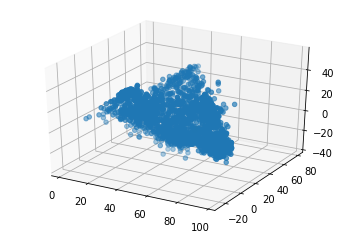

In [11]:
def data_to_Img(z):
    w,h = z[-1][0:2]
    I_out = np.zeros((int(w)+1,int(h)+1,3))
    for d in z:
        I_out[int(d[0])][int(d[1])] = d[2:]
    return I_out

I_new = data_to_Img(z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*I_luv.T) 
ax.scatter(*I_new.T)

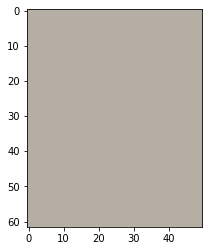

In [12]:
plt.figure()
plt.imshow(luv2rgb(I_new))

In [13]:
def ms_segmentation(z, hs, hr, dist=norm2):
    Out = []
    clusters = [z[0]]
    for i in range(len(z)):
        for j in range(len(clusters)):
            if not(dist(z[i][0:2]-clusters[j][0:2])<hs and  dist(z[i][2:]-clusters[j][2:])<hr):
                clusters.append[z[i]]